C:\Users\Dell\AppData\Local\Temp\ipykernel_13036\1351951873.py:99: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if pd.notnull(row[i]) and pd.notnull(row[i+1]) and pd.notnull(row[i+2]):
C:\Users\Dell\AppData\Local\Temp\ipykernel_13036\1351951873.py:100: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x = int(row[i])
C:\Users\Dell\AppData\Local\Temp\ipykernel_13036\1351951873.py:101: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y = in

Shape of X (microbleed features): [[1.3276780452851649 0.059501643854425065 1.1525953933965267]
 [3.5164746765491715 0.06874614842956162 1.2223727390408345]
 [1.2413478213752323 0.24095702163075158 1.1663834703619909]
 [7.2733714236134155 2.360417275042322 0.9498957949370392]
 [7.423963066528856 5.9141870148825575 1.1231526178645026]
 [0.9905946447961975 2.324449476425768 1.1447708550999882]
 [4.611083561454144 14.582060850565261 1.218410447116826]
 [1.5388950650168207 0.22882646525011127 1.1932610478820673]
 [3.423855860550176 0.3158556359078843 1.2089103286719418]
 [4.496661698300447 0.05225530078641711 1.2241076919655154]
 [1.677782255801848 0.2742943717810373 1.207329777340929]
 [4.7239765229445245 2.0836324657704752 0.9474458039239336]
 [0.28684699070685366 0.6219987192967055 0.9069935945940483]
 [3.752050748743212 3.787796324608347 1.1625852731977937]
 [7.348563180719309 1.3362254314919335 0.9898079514774023]
 [2.427140119350558 0.3987253932815711 1.2237013541529884]
 [0.29669687

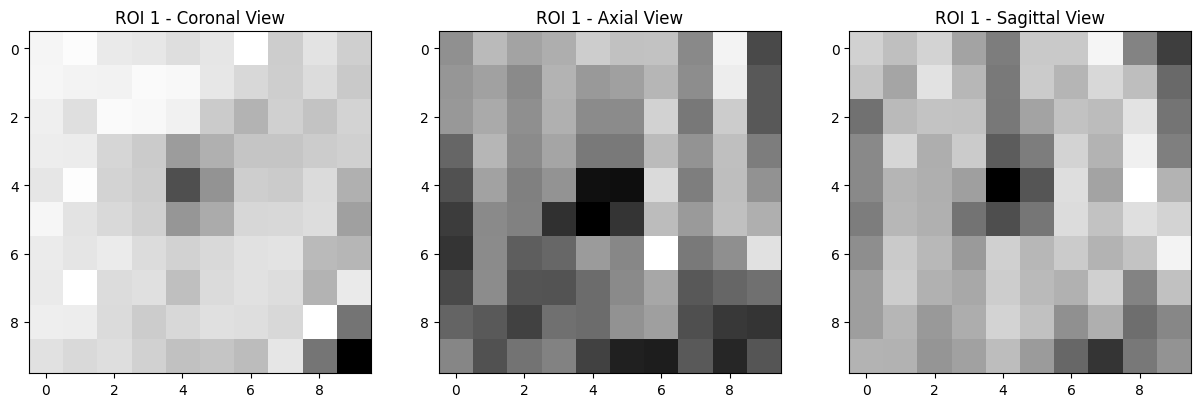

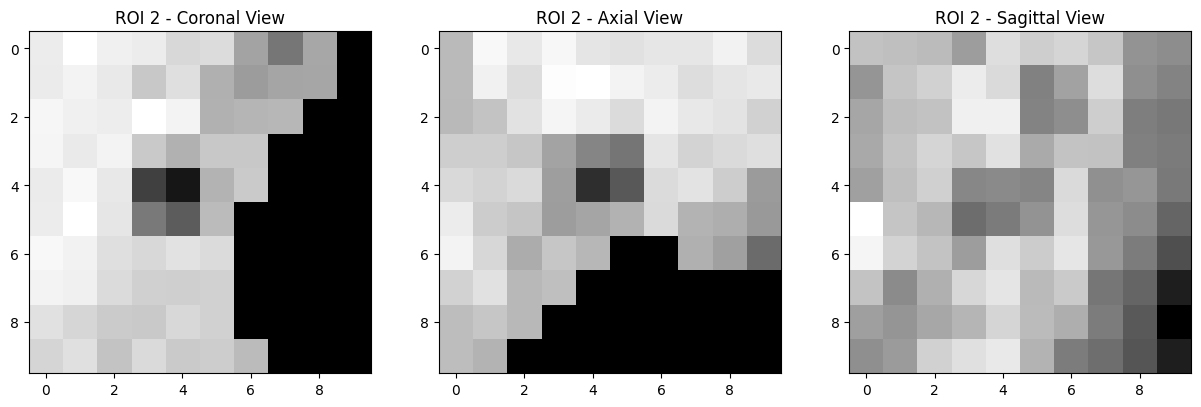

In [5]:
import pandas as pd
import os
import nibabel as nib
import numpy as np
import torch
from scipy.ndimage import gaussian_filter
from scipy import ndimage

X = []
# Define a function to extract ROIs around microbleed locations
def extract_roi(swi_data, coordinates, roi_size):
    rois = []
    for coord in coordinates:
        x, y, z = coord
        # Ensure the ROI stays within the image bounds
        x_start = max(0, x - roi_size // 2)
        x_end = min(swi_data.shape[0], x + (roi_size + 1) // 2)
        y_start = max(0, y - roi_size // 2)
        y_end = min(swi_data.shape[1], y + (roi_size + 1) // 2)
        z_start = max(0, z - roi_size // 2)
        z_end = min(swi_data.shape[2], z + (roi_size + 1) // 2)
        
        # Extract the ROI from the image data
        roi = swi_data[x_start:x_end, y_start:y_end, z_start:z_end]
        rois.append(roi)
    return rois

# Define a function to compute Hessian matrix eigenvalues
def compute_hessian_eigenvalues(roi):
    # Apply Gaussian filter to the ROI for smoothing
    smoothed_roi = gaussian_filter(roi, sigma=1)
    
    # Compute gradients along x, y, and z directions using Sobel filters
    gradient_x = ndimage.sobel(smoothed_roi, axis=0)
    gradient_y = ndimage.sobel(smoothed_roi, axis=1)
    gradient_z = ndimage.sobel(smoothed_roi, axis=2)
    
    # Compute second derivatives along x, y, and z directions
    dxx = ndimage.sobel(gradient_x, axis=0)
    dyy = ndimage.sobel(gradient_y, axis=1)
    dzz = ndimage.sobel(gradient_z, axis=2)
    dxy = ndimage.sobel(gradient_x, axis=1)
    dxz = ndimage.sobel(gradient_x, axis=2)
    dyz = ndimage.sobel(gradient_y, axis=2)
    
    # Construct the Hessian matrix
    Hessian_matrix = np.array([
        [dxx.mean(), dxy.mean(), dxz.mean()],
        [dxy.mean(), dyy.mean(), dyz.mean()],
        [dxz.mean(), dyz.mean(), dzz.mean()]
    ])
    
    # Compute eigenvalues and eigenvectors of the Hessian matrix
    eigenvalues, eigenvectors = np.linalg.eig(Hessian_matrix)
    
    return eigenvalues, eigenvectors

# Define a function to compute Hessian shape features
def compute_hessian_shape_features(eigenvalues):
    if len(eigenvalues) != 3:
        # If the number of eigenvalues is not 3, return default values or handle the case accordingly
        print("Invalid number of eigenvalues for computing features")
        return 0, 0, 0  # Return default values or handle differently if needed
    
    # Sphericalness feature
    f_sphere = abs(eigenvalues[0]) / np.sqrt(abs(eigenvalues[1] * eigenvalues[2]))
    
    # Largest cross-section feature
    f_lc = abs(eigenvalues[1]) / abs(eigenvalues[2])
    
    # Fractional anisotropy feature
    f_fa = np.sqrt(0.5) * np.sqrt((eigenvalues[0] - eigenvalues[1])**2 + 
                                  (eigenvalues[1] - eigenvalues[2])**2 + 
                                  (eigenvalues[0] - eigenvalues[2])**2) / np.sqrt((eigenvalues[0]**2 + eigenvalues[1]**2 + eigenvalues[2]**2))
    
    return f_sphere, f_lc, f_fa

# Load the Excel file containing microbleed coordinates
excel_file = 'micro-location.xlsx'  # Replace with your Excel file path
df = pd.read_excel(excel_file)

# Path to the folder containing the NIFTI images
folder_path = 'rCMB'  # Replace 'path_to_rCMB_folder' with your folder path

# Iterate through rows to load NIFTI files and extract microbleed features
for index, row in df.iterrows():
    nifti_filename = row['NIFTI']  # Assuming 'NIFTI' is the column name containing the NIFTI file names
    nifti_path = os.path.join(folder_path, nifti_filename)

    # Check if the NIFTI file exists in the folder
    if os.path.exists(nifti_path):
        swi_img = nib.load(nifti_path)
        swi_data = swi_img.get_fdata()

        # Extract microbleed coordinates for the current NIFTI file
        microbleed_coordinates = []
        for i in range(1, len(row), 3):
            try:
                if pd.notnull(row[i]) and pd.notnull(row[i+1]) and pd.notnull(row[i+2]):
                    x = int(row[i])
                    y = int(row[i+1])
                    z = int(row[i+2])
                    microbleed_coordinates.append((x, y, z))
            except (ValueError, TypeError):
                pass  # Skip non-numeric or empty values

        # Process microbleed coordinates for the current NIFTI file
        #print(f"NIFTI Filename: {nifti_filename}")
        #print(f"Microbleed Coordinates: {microbleed_coordinates}")
        #print(f"SWI Image Shape: {swi_data.shape}")
        
        # Define the size of the ROI around each microbleed
        roi_size = 10  # Adjust this according to your desired size

        # Extract ROIs around microbleed locations
        microbleed_rois = extract_roi(swi_data, microbleed_coordinates, roi_size)

        # Compute Hessian matrix and eigenvalues for each ROI
        eigenvalues_list = []
        for roi in microbleed_rois:
            eigenvalues = compute_hessian_eigenvalues(roi)
            eigenvalues_list.append(eigenvalues)

        # Compute Hessian shape features for each microbleed
        hessian_shape_features_microbleed = []
        for i, eigenvals_tuple in enumerate(eigenvalues_list):
            eigenvals = eigenvals_tuple[0]  # Unpack the nested structure
            if len(eigenvals) != 3:
                # Print the invalid eigenvalues and their count for inspection
                print(f"Invalid eigenvalues at index {i+1}: {eigenvals} (Count: {len(eigenvals)})")
                continue
            
            f_sphere, f_lc, f_fa = compute_hessian_shape_features(eigenvals)
            hessian_shape_features_microbleed.append((f_sphere, f_lc, f_fa))

        # Append the computed features to the main feature list (X)
        X.extend(hessian_shape_features_microbleed)

# Convert the list of microbleed features to a NumPy array
X1 = np.array(X,  dtype=object)

# Display the shape of the resulting feature array
print(f"Shape of X (microbleed features): {X1}")


import numpy as np
import scipy.ndimage
import nibabel as nib
import matplotlib.pyplot as plt
# Visualize individual slices for the first four ROIs
for i in range(2):
    roi = microbleed_rois[i]

    plt.figure(figsize=(15, 5))

    # Coronal View
    plt.subplot(1, 3, 1)
    plt.imshow(roi[:, :, roi.shape[2]//2], cmap='gray')
    plt.title(f"ROI {i+1} - Coronal View")

    # Axial View
    plt.subplot(1, 3, 2)
    plt.imshow(roi[roi.shape[0]//2, :, :], cmap='gray')
    plt.title(f"ROI {i+1} - Axial View")

    # Sagittal View
    plt.subplot(1, 3, 3)
    plt.imshow(roi[:, roi.shape[2]//2, :], cmap='gray')
    plt.title(f"ROI {i+1} - Sagittal View")

    plt.show()

In [2]:
import pandas as pd
import os
import nibabel as nib
import numpy as np
import torch
from scipy.ndimage import gaussian_filter
from scipy import ndimage

X = []
# Define a function to extract ROIs around microbleed locations
def extract_roi(swi_data, coordinates, roi_size):
    rois = []
    for coord in coordinates:
        x, y, z = coord
        # Ensure the ROI stays within the image bounds
        x_start = max(0, x - roi_size // 2)
        x_end = min(swi_data.shape[0], x + (roi_size + 1) // 2)
        y_start = max(0, y - roi_size // 2)
        y_end = min(swi_data.shape[1], y + (roi_size + 1) // 2)
        z_start = max(0, z - roi_size // 2)
        z_end = min(swi_data.shape[2], z + (roi_size + 1) // 2)
        
        # Extract the ROI from the image data
        roi = swi_data[x_start:x_end, y_start:y_end, z_start:z_end]
        rois.append(roi)
    return rois

# Define a function to compute Hessian matrix eigenvalues
def compute_hessian_eigenvalues(roi):
    # Apply Gaussian filter to the ROI for smoothing
    smoothed_roi = gaussian_filter(roi, sigma=1)
    
    # Compute gradients along x, y, and z directions using Sobel filters
    gradient_x = ndimage.sobel(smoothed_roi, axis=0)
    gradient_y = ndimage.sobel(smoothed_roi, axis=1)
    gradient_z = ndimage.sobel(smoothed_roi, axis=2)
    
    # Compute second derivatives along x, y, and z directions
    dxx = ndimage.sobel(gradient_x, axis=0)
    dyy = ndimage.sobel(gradient_y, axis=1)
    dzz = ndimage.sobel(gradient_z, axis=2)
    dxy = ndimage.sobel(gradient_x, axis=1)
    dxz = ndimage.sobel(gradient_x, axis=2)
    dyz = ndimage.sobel(gradient_y, axis=2)
    
    # Construct the Hessian matrix
    Hessian_matrix = np.array([
        [dxx.mean(), dxy.mean(), dxz.mean()],
        [dxy.mean(), dyy.mean(), dyz.mean()],
        [dxz.mean(), dyz.mean(), dzz.mean()]
    ])
    
    # Compute eigenvalues and eigenvectors of the Hessian matrix
    eigenvalues, eigenvectors = np.linalg.eig(Hessian_matrix)
    
    return eigenvalues, eigenvectors

# Define a function to compute Hessian shape features
def compute_hessian_shape_features(eigenvalues):
    if len(eigenvalues) != 3:
        # If the number of eigenvalues is not 3, return default values or handle the case accordingly
        print("Invalid number of eigenvalues for computing features")
        return 0, 0, 0  # Return default values or handle differently if needed
    
    # Sphericalness feature
    f_sphere = abs(eigenvalues[0]) / np.sqrt(abs(eigenvalues[1] * eigenvalues[2]))
    
    # Largest cross-section feature
    f_lc = abs(eigenvalues[1]) / abs(eigenvalues[2])
    
    # Fractional anisotropy feature
    f_fa = np.sqrt(0.5) * np.sqrt((eigenvalues[0] - eigenvalues[1])**2 + 
                                  (eigenvalues[1] - eigenvalues[2])**2 + 
                                  (eigenvalues[0] - eigenvalues[2])**2) / np.sqrt((eigenvalues[0]**2 + eigenvalues[1]**2 + eigenvalues[2]**2))
    
    return f_sphere, f_lc, f_fa

# Load the Excel file containing microbleed coordinates
excel_file = 'micro-location.xlsx'  # Replace with your Excel file path
df = pd.read_excel(excel_file)

# Path to the folder containing the NIFTI images
folder_path = 'rCMB'  # Replace 'path_to_rCMB_folder' with your folder path

# Iterate through rows to load NIFTI files and extract microbleed features
for index, row in df.iterrows():
    nifti_filename = row['NIFTI']  # Assuming 'NIFTI' is the column name containing the NIFTI file names
    nifti_path = os.path.join(folder_path, nifti_filename)

    # Check if the NIFTI file exists in the folder
    if os.path.exists(nifti_path):
        swi_img = nib.load(nifti_path)
        swi_data = swi_img.get_fdata()

        # Extract microbleed coordinates for the current NIFTI file
        microbleed_coordinates = []
        for i in range(1, len(row), 3):
            try:
                if pd.notnull(row[i]) and pd.notnull(row[i+1]) and pd.notnull(row[i+2]):
                    x = int(row[i])
                    y = int(row[i+1])
                    z = int(row[i+2])
                    microbleed_coordinates.append((x, y, z))
            except (ValueError, TypeError):
                pass  # Skip non-numeric or empty values

        # Define the size of the ROI around each microbleed
        roi_size = 10  # Adjust this according to your desired size

        # Extract ROIs around microbleed locations
        microbleed_rois = extract_roi(swi_data, microbleed_coordinates, roi_size)

        # Compute Hessian matrix and eigenvalues for each ROI
        eigenvalues_list = []
        for roi in microbleed_rois:
            eigenvalues = compute_hessian_eigenvalues(roi)
            eigenvalues_list.append(eigenvalues)

        # Compute Hessian shape features for each microbleed
        hessian_shape_features_microbleed = []
        for i, eigenvals_tuple in enumerate(eigenvalues_list):
            eigenvals = eigenvals_tuple[0]  # Unpack the nested structure
            if len(eigenvals) != 3:
                # Print the invalid eigenvalues and their count for inspection
                print(f"Invalid eigenvalues at index {i+1}: {eigenvals} (Count: {len(eigenvals)})")
                continue
            
            f_sphere, f_lc, f_fa = compute_hessian_shape_features(eigenvals)
            hessian_shape_features_microbleed.append((f_sphere, f_lc, f_fa))

        # Append the computed features to the main feature list (X)
        X.extend(hessian_shape_features_microbleed)

# Convert the list of microbleed features to a NumPy array
X1 = np.array(X)

# Display the shape of the resulting feature array
print(f"Shape of X (microbleed features): {X1}")

Shape of X (microbleed features): []


In [3]:
# Assuming X contains the microbleed features

# Determine the number of microbleeds in X
num_microbleeds = X1.shape[0]

# Set the labels for microbleeds as 1
Y1 = np.ones(num_microbleeds)

# Display the shape of the label array
print(f"Shape of Y1 (labels): {Y1.shape}")

# Display a few labels to confirm that 
print(Y1)  # Displaying the first 10 labels as an example

Shape of Y1 (labels): (0,)
[]


In [1]:
import pandas as pd
import os
import nibabel as nib
import numpy as np
from scipy.ndimage import gaussian_filter
from scipy import ndimage



X = []
# Define a function to extract ROIs around microbleed locations
def extract_roi(swi_data, coordinates, roi_size):
    rois = []
    for coord in coordinates:
        x, y, z = coord
        # Ensure the ROI stays within the image bounds
        x_start = max(0, x - roi_size // 2)
        x_end = min(swi_data.shape[0], x + (roi_size + 1) // 2)
        y_start = max(0, y - roi_size // 2)
        y_end = min(swi_data.shape[1], y + (roi_size + 1) // 2)
        z_start = max(0, z - roi_size // 2)
        z_end = min(swi_data.shape[2], z + (roi_size + 1) // 2)
        
        # Extract the ROI from the image data
        roi = swi_data[x_start:x_end, y_start:y_end, z_start:z_end]
        rois.append(roi)
    return rois

# Define a function to compute Hessian matrix eigenvalues
def compute_hessian_eigenvalues(roi):
    # Apply Gaussian filter to the ROI for smoothing
    smoothed_roi = gaussian_filter(roi, sigma=1)
    
    # Compute gradients along x, y, and z directions using Sobel filters
    gradient_x = ndimage.sobel(smoothed_roi, axis=0)
    gradient_y = ndimage.sobel(smoothed_roi, axis=1)
    gradient_z = ndimage.sobel(smoothed_roi, axis=2)
    
    # Compute second derivatives along x, y, and z directions
    dxx = ndimage.sobel(gradient_x, axis=0)
    dyy = ndimage.sobel(gradient_y, axis=1)
    dzz = ndimage.sobel(gradient_z, axis=2)
    dxy = ndimage.sobel(gradient_x, axis=1)
    dxz = ndimage.sobel(gradient_x, axis=2)
    dyz = ndimage.sobel(gradient_y, axis=2)
    
    # Construct the Hessian matrix
    Hessian_matrix = np.array([
        [dxx.mean(), dxy.mean(), dxz.mean()],
        [dxy.mean(), dyy.mean(), dyz.mean()],
        [dxz.mean(), dyz.mean(), dzz.mean()]
    ])
    
    # Compute eigenvalues and eigenvectors of the Hessian matrix
    eigenvalues, eigenvectors = np.linalg.eig(Hessian_matrix)
    
    return eigenvalues, eigenvectors

# Define a function to compute Hessian shape features
def compute_hessian_shape_features(eigenvalues):
    if len(eigenvalues) != 3:
        # If the number of eigenvalues is not 3, return default values or handle the case accordingly
        print("Invalid number of eigenvalues for computing features")
        return 0, 0, 0  # Return default values or handle differently if needed
    
    # Sphericalness feature
    f_sphere = abs(eigenvalues[0]) / np.sqrt(abs(eigenvalues[1] * eigenvalues[2]))
    
    # Largest cross-section feature
    f_lc = abs(eigenvalues[1]) / abs(eigenvalues[2])
    
    # Fractional anisotropy feature
    f_fa = np.sqrt(0.5) * np.sqrt((eigenvalues[0] - eigenvalues[1])**2 + 
                                  (eigenvalues[1] - eigenvalues[2])**2 + 
                                  (eigenvalues[0] - eigenvalues[2])**2) / np.sqrt((eigenvalues[0]**2 + eigenvalues[1]**2 + eigenvalues[2]**2))
    
    return f_sphere, f_lc, f_fa

# Load the Excel file containing microbleed coordinates
excel_file = 'NoCMB.xlsx'  # Replace with your Excel file path
df = pd.read_excel(excel_file)

# Path to the folder containing the NIFTI images
folder_path = 'noncmb'  # Replace 'path_to_rCMB_folder' with your folder path

# Iterate through rows to load NIFTI files and extract microbleed features
for index, row in df.iterrows():
    nifti_filename = row['NIFTI']  # Assuming 'NIFTI' is the column name containing the NIFTI file names
    nifti_path = os.path.join(folder_path, nifti_filename)

    # Check if the NIFTI file exists in the folder
    if os.path.exists(nifti_path):
        swi_img = nib.load(nifti_path)
        swi_data = swi_img.get_fdata()

        # Extract microbleed coordinates for the current NIFTI file
        microbleed_coordinates = []
        for i in range(1, len(row), 3):
            try:
                if pd.notnull(row[i]) and pd.notnull(row[i+1]) and pd.notnull(row[i+2]):
                    x = int(row[i])
                    y = int(row[i+1])
                    z = int(row[i+2])
                    microbleed_coordinates.append((x, y, z))
            except (ValueError, TypeError):
                pass  # Skip non-numeric or empty values

        # Process microbleed coordinates for the current NIFTI file
        #print(f"NIFTI Filename: {nifti_filename}")
        #print(f"Microbleed Coordinates: {microbleed_coordinates}")
        #print(f"SWI Image Shape: {swi_data.shape}")
        
        # Define the size of the ROI around each microbleed
        roi_size = 10  # Adjust this according to your desired size

        # Extract ROIs around microbleed locations
        microbleed_rois = extract_roi(swi_data, microbleed_coordinates, roi_size)

        # Compute Hessian matrix and eigenvalues for each ROI
        eigenvalues_list = []
        for roi in microbleed_rois:
            eigenvalues = compute_hessian_eigenvalues(roi)
            eigenvalues_list.append(eigenvalues)

        # Compute Hessian shape features for each microbleed
        hessian_shape_features_microbleed = []
        for i, eigenvals_tuple in enumerate(eigenvalues_list):
            eigenvals = eigenvals_tuple[0]  # Unpack the nested structure
            if len(eigenvals) != 3:
                # Print the invalid eigenvalues and their count for inspection
                print(f"Invalid eigenvalues at index {i+1}: {eigenvals} (Count: {len(eigenvals)})")
                continue
            
            f_sphere, f_lc, f_fa = compute_hessian_shape_features(eigenvals)
            hessian_shape_features_microbleed.append((f_sphere, f_lc, f_fa))

        # Append the computed features to the main feature list (X)
        X.extend(hessian_shape_features_microbleed)

# Convert the list of microbleed features to a NumPy array
X0 = np.array(X)

# Display the shape of the resulting feature array
print(f"Shape of X (non microbleed features): {X0}")


C:\Users\Dell\AppData\Local\Temp\ipykernel_3320\3917686042.py:100: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if pd.notnull(row[i]) and pd.notnull(row[i+1]) and pd.notnull(row[i+2]):
C:\Users\Dell\AppData\Local\Temp\ipykernel_3320\3917686042.py:101: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x = int(row[i])
C:\Users\Dell\AppData\Local\Temp\ipykernel_3320\3917686042.py:102: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y = int(

Shape of X (non microbleed features): [[6.36109412e+00 1.78485560e-01 1.16708038e+00]
 [2.18786517e+00 4.15165032e-01 1.22474295e+00]
 [1.77420719e+00 6.44962652e-02 1.15926498e+00]
 [6.12282670e+00 4.42516792e+00 1.12263418e+00]
 [3.54654334e+00 2.55395797e-01 1.21091053e+00]
 [3.20422375e+01 4.65079151e-02 9.30486840e-01]
 [1.13090149e+00 4.50172400e-01 1.16858960e+00]
 [1.53420204e+01 1.31399581e+01 1.10032242e+00]
 [1.62912810e+00 5.10285691e+00 1.19485660e+00]
 [1.02637239e-01 5.01151327e-01 1.19487107e+00]
 [3.18729385e+00 1.96003616e-01 1.19965543e+00]
 [4.38224643e+00 2.17180186e+00 7.22686025e-01]
 [1.34485269e+00 2.44519517e+00 1.19205404e+00]
 [1.36619914e+00 2.66923884e+00 1.19214418e+00]
 [5.28601971e+00 7.77699313e+00 1.19841611e+00]
 [1.36477608e+00 5.06644341e-01 1.19787667e+00]
 [2.10604068e+00 8.25989285e-01 1.22444871e+00]
 [1.39458267e+00 1.07980262e+00 1.10725211e+00]
 [4.14219438e+00 1.73409370e+01 1.22433874e+00]
 [3.64922051e+00 1.75394073e+00 1.19215173e+00]
 [

In [4]:
# Assuming X contains the microbleed features

# Determine the number of microbleeds in X
num_microbleeds = X0.shape[0]

# Set the labels for microbleeds as 1
Y0 = np.zeros(num_microbleeds)

# Display the shape of the label array
print(f"Shape of Y0 (labels): {Y0.shape}")

# Display a few labels to confirm
print(Y0)  # Displaying the first 10 labels as an example


Shape of Y0 (labels): (300,)
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


In [5]:
X = np.vstack((X1,X0))
print(X.shape)

# Create corresponding labels 'y' (1 for microbleeds, 0 for non-microbleeds)
Y = np.hstack((Y1,Y0))
print(Y.shape)

(446, 3)
(446,)


In [6]:
from sklearn.model_selection import LeaveOneOut, cross_val_predict
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import numpy as np


def layer1(X_train, y_train):
    # Define your classifier (Random Forest Classifier)
    clf = RandomForestClassifier(random_state=42)
    clf.fit(X_train, y_train)

    # Fit the classifier on the entire dataset to obtain predictions
    y_pred =  clf.predict(X_train)

    # Extract positively predicted samples and their labels
    positively_predicted_samples1 = X_train[y_pred == y_train]
    actual_labels_positively_predicted1 = y_train[y_pred == y_train]


    return positively_predicted_samples1, actual_labels_positively_predicted1

# Assuming X and Y are your original datasets
def layer2(X_layer1, y_layer1):

    # Define your classifier (Random Forest Classifier)
    clf = RandomForestClassifier(random_state=42)
    clf.fit(X_layer1, y_layer1)

    # Fit the classifier on the entire dataset to obtain predictions
    y_pred =  clf.predict(X_layer1)

    # Extract positively predicted samples and their labels
    positively_predicted_samples2 = X_layer1[y_pred == y_layer1]
    actual_labels_positively_predicted2 = y_layer1[y_pred == y_layer1]
    return positively_predicted_samples2, actual_labels_positively_predicted2,clf

# Placeholder for results
final_layer_accuracies = []

# Create a Leave-One-Out Cross-Validator
loo = LeaveOneOut()

# Iterate through the Leave-One-Out splits
for test_index in range(len(X)):
    # Create training set (X_train, Y_train) without the test data point
    X_train = np.delete(X, test_index, axis=0)
    Y_train = np.delete(Y, test_index)

    # Call layer1 function
    positively_predicted_samples1, actual_labels_positively_predicted1 = layer1(X_train, Y_train)

    # Call layer2 function using the output of layer1
    positively_predicted_samples2, actual_labels_positively_predicted2,clf  = layer2(positively_predicted_samples1, actual_labels_positively_predicted1)

    # Create training set using only layer3 output
    X_final_layer = positively_predicted_samples2
    Y_final_layer = actual_labels_positively_predicted2

    # Test on the left-out data point from the original dataset
    y_pred_final_layer = clf.predict(X[test_index].reshape(1, -1))

    # Calculate accuracy for the fold
    accuracy_final_layer = accuracy_score([Y[test_index]], y_pred_final_layer)

    # Store results
    final_layer_accuracies.append(accuracy_final_layer)

    # Print information for the current iteration
    print(f"Iteration {test_index + 1}:")
    print(f"Test Data: {X[test_index]}")
    print(f"Actual Label: {Y[test_index]}")
    print(f"Predicted Label (Final Layer): {y_pred_final_layer}")
    print(f"Accuracy (Final Layer): {accuracy_final_layer}")
    print()

# Calculate mean accuracy for the final layer
mean_accuracy_final_layer = np.mean(final_layer_accuracies)
print("Mean Accuracy (Final Layer):", mean_accuracy_final_layer)

Iteration 1:
Test Data: [1.32767805 0.05950164 1.15259539]
Actual Label: 1.0
Predicted Label (Final Layer): [0.]
Accuracy (Final Layer): 0.0

Iteration 2:
Test Data: [3.51647468 0.06874615 1.22237274]
Actual Label: 1.0
Predicted Label (Final Layer): [1.]
Accuracy (Final Layer): 1.0

Iteration 3:
Test Data: [1.24134782 0.24095702 1.16638347]
Actual Label: 1.0
Predicted Label (Final Layer): [0.]
Accuracy (Final Layer): 0.0

Iteration 4:
Test Data: [7.27337142 2.36041728 0.94989579]
Actual Label: 1.0
Predicted Label (Final Layer): [1.]
Accuracy (Final Layer): 1.0

Iteration 5:
Test Data: [7.42396307 5.91418701 1.12315262]
Actual Label: 1.0
Predicted Label (Final Layer): [0.]
Accuracy (Final Layer): 0.0

Iteration 6:
Test Data: [0.99059464 2.32444948 1.14477086]
Actual Label: 1.0
Predicted Label (Final Layer): [0.]
Accuracy (Final Layer): 0.0

Iteration 7:
Test Data: [ 4.61108356 14.58206085  1.21841045]
Actual Label: 1.0
Predicted Label (Final Layer): [1.]
Accuracy (Final Layer): 1.0

Ite

function

In [7]:
from sklearn.model_selection import LeaveOneOut, cross_val_score, cross_val_predict
from sklearn.ensemble import RandomForestClassifier
import numpy as np

def layer1(X_train, y_train):
    # Define your classifier (Random Forest Classifier)
    clf = RandomForestClassifier(random_state=42)

    # Create a Leave-One-Out Cross-Validator
    loo = LeaveOneOut()

    accuracies = 0

    # Perform cross-validation and get accuracy for each iteration
    #accuracies = cross_val_score(clf, X_train, y_train, cv=loo)

    # Fit the classifier on the entire dataset to obtain predictions
    y_pred = cross_val_predict(clf, X_train, y_train, cv=loo, n_jobs=7)

    # Extract positively predicted samples and their labels
    positively_predicted_samples1 = X_train[y_pred == y_train]
    actual_labels_positively_predicted1 = y_train[y_pred == y_train]


    return positively_predicted_samples1, actual_labels_positively_predicted1



In [8]:
from sklearn.model_selection import LeaveOneOut, cross_val_score, cross_val_predict
from sklearn.ensemble import RandomForestClassifier
import numpy as np

def layer2(X_layer1, y_layer1):
    # Define your classifier (Random Forest Classifier)
    clf = RandomForestClassifier(random_state=42)

    # Create a Leave-One-Out Cross-Validator
    loo = LeaveOneOut()

    accuracies = 0

    # Perform cross-validation and get accuracy for each iteration
    #accuracies = cross_val_score(clf, X_layer1, y_layer1, cv=loo)

    # Fit the classifier on the entire dataset to obtain predictions
    y_pred = cross_val_predict(clf, X_layer1, y_layer1, cv=loo)

    # Extract positively predicted samples and their labels
    positively_predicted_samples2 = X_layer1[y_pred == y_layer1]
    actual_labels_positively_predicted2 = y_layer1[y_pred == y_layer1]

    clf.fit(X_layer1, y_layer1)


    # Return results if needed
    return positively_predicted_samples2, actual_labels_positively_predicted2,clf


In [9]:
from sklearn.model_selection import LeaveOneOut, cross_val_score, cross_val_predict
from sklearn.ensemble import RandomForestClassifier
import numpy as np

def layer3(X_layer2, y_layer2):
    # Define your classifier (Random Forest Classifier)
    clf = RandomForestClassifier(random_state=42)

    # Create a Leave-One-Out Cross-Validator
    loo = LeaveOneOut()


    accuracies = 0

    # Perform cross-validation and get accuracy for each iteration
    #accuracies = cross_val_score(clf, X_layer2, y_layer2, cv=loo)


    # Fit the classifier on the entire dataset to obtain predictions
    y_pred = cross_val_predict(clf, X_layer2, y_layer2, cv=loo, n_jobs=6)

    # Extract positively predicted samples and their labels
    positively_predicted_samples3 = X_layer2[y_pred == y_layer2]
    actual_labels_positively_predicted3 = y_layer2[y_pred == y_layer2]

    # Print mean accuracy and extracted samples
    mean_accuracy = np.mean(accuracies)
    clf.fit(X_layer2, y_layer2)
    # Test on the left-out data point from the original dataset
    

    #print("\nMean Accuracy (Layer 3):", mean_accuracy)
    #print("\nPositively Predicted Samples (Layer 3):")
    #print(positively_predicted_samples.shape)
    #print("\nCorresponding Labels (Layer 3):")
    #print(actual_labels_positively_predicted.shape)

    # Return results if needed otherwise you shouldn't return anything 
    return positively_predicted_samples3, actual_labels_positively_predicted3, clf

In [10]:
from sklearn.model_selection import LeaveOneOut
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import numpy as np

# Assuming X and Y are your original datasets

# Placeholder for results
final_layer_accuracies = []

# Create a Leave-One-Out Cross-Validator
loo = LeaveOneOut()

# Iterate through the Leave-One-Out splits
for test_index in range(len(X)):
    # Create training set (X_train, Y_train) without the test data point
    X_train = np.delete(X, test_index, axis=0)
    Y_train = np.delete(Y, test_index)

    # Call layer1 function
    positively_predicted_samples1, actual_labels_positively_predicted1 = layer1(X_train, Y_train)

    # Call layer2 function using the output of layer1
    positively_predicted_samples2, actual_labels_positively_predicted2,clf  = layer2(positively_predicted_samples1, actual_labels_positively_predicted1)

    # Create training set using only layer3 output
    X_final_layer = positively_predicted_samples2
    Y_final_layer = actual_labels_positively_predicted2

    # Test on the left-out data point from the original dataset
    y_pred_final_layer = clf.predict(X[test_index].reshape(1, -1))

    # Calculate accuracy for the fold
    accuracy_final_layer = accuracy_score([Y[test_index]], y_pred_final_layer)

    # Store results
    final_layer_accuracies.append(accuracy_final_layer)

    # Print information for the current iteration
    print(f"Iteration {test_index + 1}:")
    print(f"Test Data: {X[test_index]}")
    print(f"Actual Label: {Y[test_index]}")
    print(f"Predicted Label (Final Layer): {y_pred_final_layer}")
    print(f"Accuracy (Final Layer): {accuracy_final_layer}")
    print()

# Calculate mean accuracy for the final layer
mean_accuracy_final_layer = np.mean(final_layer_accuracies)
print("Mean Accuracy (Final Layer):", mean_accuracy_final_layer)

Parallelizing For loops

In [ ]:

from sklearn.model_selection import LeaveOneOut
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from joblib import Parallel, delayed
import numpy as np

# Assuming X and Y are your original datasets

# Placeholder for results
final_layer_accuracies = []

# Create a Leave-One-Out Cross-Validator
loo = LeaveOneOut()

def process_iteration(test_index, X, Y):
    # Create training set (X_train, Y_train) without the test data point
    X_train = np.delete(X, test_index, axis=0)
    Y_train = np.delete(Y, test_index)

    # Call layer1 function
    positively_predicted_samples1, actual_labels_positively_predicted1 = layer1(X_train, Y_train)

    # Call layer2 function using the output of layer1
    positively_predicted_samples2, actual_labels_positively_predicted2, clf = layer2(positively_predicted_samples1, actual_labels_positively_predicted1)

    # Call layer3 function using the output of layer2
    # positively_predicted_samples3, actual_labels_positively_predicted3, clf = layer3(positively_predicted_samples2, actual_labels_positively_predicted2)

    # Create training set using only layer3 output
    X_final_layer = positively_predicted_samples2
    Y_final_layer = actual_labels_positively_predicted2

    # Test on the left-out data point from the original dataset
    y_pred_final_layer = clf.predict(X[test_index].reshape(1, -1))

    # Calculate accuracy for the fold
    accuracy_final_layer = accuracy_score([Y[test_index]], y_pred_final_layer)

   
    return accuracy_final_layer

# Parallelize the loop
final_layer_accuracies = Parallel(n_jobs= 7)(delayed(process_iteration)(test_index, X, Y) for test_index in range(len(X)))

# Calculate mean accuracy for the final layer
mean_accuracy_final_layer = np.mean(final_layer_accuracies)
print("Mean Accuracy (Final Layer):", mean_accuracy_final_layer)


